In [1]:
from fuzzyART_gai import *
from handytools import *
import sklearn.datasets as ds
import sklearn.decomposition as dcp
import matplotlib.pyplot as plt
#import matplotlib.patches as pch
from scipy.spatial import ConvexHull

In [2]:
iris = ds.load_iris()
data = iris['data'] / np.max(iris['data'], axis=0)
label_true = iris['target']
featnum = data.shape[1]
# pca
pca = dcp.PCA(n_components=2)
pca_xy = pca.fit_transform(data)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

[0.92138578 0.05142129]
[4.9602239  1.17179601]


0.0
figure saved at _simcache/2022-03-29_22-41-19_var_rho0
0.1111111111111111
figure saved at _simcache/2022-03-29_22-41-19_var_rho11
0.2222222222222222
figure saved at _simcache/2022-03-29_22-41-20_var_rho22
0.3333333333333333
figure saved at _simcache/2022-03-29_22-41-21_var_rho33
0.4444444444444444
figure saved at _simcache/2022-03-29_22-41-22_var_rho44
0.5555555555555556
figure saved at _simcache/2022-03-29_22-41-22_var_rho55
0.6666666666666666
figure saved at _simcache/2022-03-29_22-41-23_var_rho66
0.7777777777777777


QhullError: QH6154 Qhull precision error: Initial simplex is flat (facet 1 is coplanar with the interior point)

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 1019528194  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width 1.1e-16  Error-roundoff 4.5e-16  _one-merge 2.2e-15
  _near-inside 1.1e-14  Visible-distance 8.9e-16  U-max-coplanar 8.9e-16
  Width-outside 1.8e-15  _wide-facet 5.4e-15  _maxoutside 2.7e-15

The input to qhull appears to be less than 2 dimensional, or a
computation has overflowed.

Qhull could not construct a clearly convex simplex from points:
- p2(v3): -0.61 -0.086
- p1(v2): -0.61 -0.086
- p0(v1): -0.61 -0.086

The center point is coplanar with a facet, or a vertex is coplanar
with a neighboring facet.  The maximum round off error for
computing distances is 4.5e-16.  The center point, facets and distances
to the center point are as follows:

center point   -0.609 -0.08638

facet p1 p0 distance= -1.4e-17
facet p2 p0 distance= -3.5e-17
facet p2 p1 distance= 1.4e-17

These points either have a maximum or minimum x-coordinate, or
they maximize the determinant for k coordinates.  Trial points
are first selected from points that maximize a coordinate.

The min and max coordinates for each dimension are:
  0:    -0.609  -2.225e-308  difference= 0.609
  1:  -0.08638  -2.225e-308  difference= 0.08638

If the input should be full dimensional, you have several options that
may determine an initial simplex:
  - use 'QJ'  to joggle the input and make it full dimensional
  - use 'QbB' to scale the points to the unit cube
  - use 'QR0' to randomly rotate the input for different maximum points
  - use 'Qs'  to search all points for the initial simplex
  - use 'En'  to specify a maximum roundoff error less than 4.5e-16.
  - trace execution with 'T3' to see the determinant for each point.

If the input is lower dimensional:
  - use 'QJ' to joggle the input and make it full dimensional
  - use 'Qbk:0Bk:0' to delete coordinate k from the input.  You should
    pick the coordinate with the least range.  The hull will have the
    correct topology.
  - determine the flat containing the points, rotate the points
    into a coordinate plane, and delete the other coordinates.
  - add one or more points to make the input full dimensional.


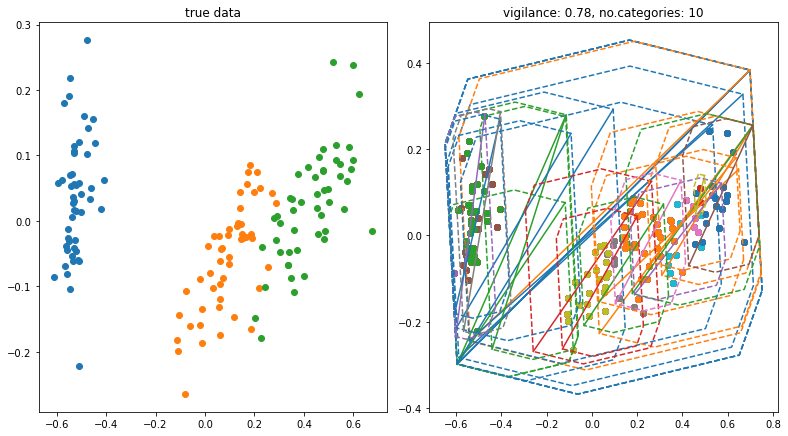

In [4]:
no_rho = 10
ls_rho = np.linspace(0, 1, no_rho)
fig, axs = plt.subplots(1, 2,
                        figsize = (11, 6))
fig.tight_layout()

# plot true
for cat_true in range(3):
    axs[0].scatter(*np.where(label_true == cat_true, pca_xy.T, None))
axs[0].set_title('true data')

ax = axs[1]
for rho in ls_rho: 
    print(rho)
    # init
    net = FuzzyARTgai(alpha=0.5, rho=rho)
    
    # train
    net.train(data, epochs=100) # each epoch, all data is shuffled
    label_pred = net.test(data).astype(int)

    # plot 
    cat_number = net.w.shape[0]
    cat_centre = pca.transform(net.w[:, :4])
    for cat_pred, cat_x, cat_y in zip(range(cat_number), *cat_centre.T):
        c = next(ax._get_lines.prop_cycler)['color']
        ax.scatter(*np.where(label_pred == cat_pred, pca_xy.T, None), color = c) # all training samples
 #       ax.scatter(cat_x, cat_y, marker = 'x', s = 100, color = c) # categorical centre
    ax.set_title('vigilance: {:.2f}, no.categories: {}'.format(rho, cat_number))
    
 #   if 1 < cat_number:
  #      # interplot 2 cats
   #     inter01 = pca.transform([np.mean(net.w[:2, :4], axis = 0)])
    #    ax.scatter(*inter01.T, marker = 'o', s = 200, edgecolors = 'k', facecolors='none')
     #   interpca01 = np.mean(cat_centre[:2], axis = 0)
      #  ax.scatter(*interpca01.T, marker = 'x', s = 200, c = 'k')
       # ax.plot(*cat_centre[:2].T, c = 'k')
        
    # add boundary?
    rec_blxy, rec_trxy = [pca.transform(_) for _ in net.getcat_bipolars()] # w = (u, v^c), where v^c = 1 - v
    
    ax.set_prop_cycle(None)
    for bl, tr in zip(rec_blxy, rec_trxy):
        ax.plot(*np.transpose([bl, tr]))
    #ax.plot(*rec_blxy.T, marker='^')    
    
    ax.set_prop_cycle(None)
    for points in net.getcat_vertices():
        points2d = pca.transform(points)
        hull = ConvexHull(points2d)
        hullxy = np.append(hull.vertices, hull.vertices[0])
        ax.plot(points2d[hullxy, 0], points2d[hullxy, 1], '--')  
    
    # save fig
    simname = 'var_rho{:d}'.format(int(rho*100))
    dirname = '_simcache'
    savefigure_datetime(fig, simname, dirname)